In [1]:
# !pip3 install pandas
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import json
import tikzplotlib

pd.set_option('display.max_rows', 200)
pd.set_option("display.precision", 2)
plt.style.use('dark_background')

In [2]:
BASE_DIR = '/Users/dfilipiak/repositories/publikacje/PUB-2021-OneShotKG'
PROJECT_DIR = f'{BASE_DIR}/KGTN2'
FIGURES_DIR = f'{BASE_DIR}/figures'

# Helper functions

### Result parser from KGTN paper

In [58]:
def parse_results(resultsdir, repr, lr, wd, printing=False, results_aggreagation='mean'):
    outpath = '{}_' + 'lr_{:.3f}_wd_{:.3f}'.format(lr, wd) + '_expid_{:d}_lowshotn_{:d}.json' 
    lowshotns = [1,2,5, 10]
    expids = [1,2,3,4,5]
    all_nums = np.zeros((len(lowshotns), len(expids), 4))
    for i, ei in enumerate(expids):
        for j, ln in enumerate(lowshotns):
            outfile = os.path.join(resultsdir, outpath.format(repr, ei, ln))
            with open(outfile, 'r') as f:
                out = json.load(f)
                all_nums[j,i,:] = np.array(out['accs'])*100

    if results_aggreagation == "std":
        means = np.std(all_nums, axis=1)
    elif results_aggreagation == "max":
        means = np.max(all_nums, axis=1)
    else:
        means = np.mean(all_nums, axis=1)

    if printing:
        print('n \tNovel17 Novel18 All    All with prior')
        print('  \tTop-5   Top-5   Top-5  Top-5')
        
        print('='*80)

        to_print = '\n'.join([str(lowshotns[i])+'\t'+'\t'.join(['{:.2f}'.format(x) for x in y]) for i, y in enumerate(means)])
        print(to_print)
        print('='*80)
        mean_mean = np.mean(means, axis=0)
        print('mean\t'+'\t'.join(['{:.2f}'.format(x) for x in mean_mean]))
    else:
        results = means[:, 1:3].transpose()
        
        novel = {k: v for k, v in zip(lowshotns, results[0].squeeze())}
        novel['type'] = 'novel'
        novel['label'] = resultsdir
        
        all = {k: v for k, v in zip(lowshotns, results[1].squeeze())}
        all['type'] = 'all'
        all['label'] = resultsdir

        return novel, all

### Results DF

In [59]:
def __add_experiment_paths(experiment_paths, feature_extractor, lr=0.01, wd=0.0001, baseline_lr=0.1, results_aggreagation='mean'):
    results = []
    for experiment_path in experiment_paths:
        current_lr = baseline_lr if experiment_path.rsplit("/", 1)[-1] == "baseline" else lr
        r_novel, r_all = parse_results(experiment_path, feature_extractor, current_lr, wd, results_aggreagation=results_aggreagation)
        results.append(r_novel), results.append(r_all)

    return pd.DataFrame(results)

def __replace_labels(df, aggregation_function, similarity_function):
    df['label'] = df['label'].apply(lambda x: x.split('/')[-1])
    df['label'] = df['label'].replace([f'{similarity_function}'], 'KGTN (g)')
    df['label'] = df['label'].replace([f'hierarchy,glove-{aggregation_function}-{similarity_function}'], 'KGTN-ens (h+g)')
    df['label'] = df['label'].replace([f'wiki,glove-{aggregation_function}-{similarity_function}'], 'KGTN-ens (w+g)')
    df['label'] = df['label'].replace([f'wiki,hierarchy-{aggregation_function}-{similarity_function}'], 'KGTN-ens (w+h)')
    df['label'] = df['label'].replace([f'wiki,hierarchy,glove-{aggregation_function}-{similarity_function}'], 'KGTN-ens (w+h+g)')
    # df = df.set_index(['type', 'label'])
    return df

def get_experiment_df(experiment_paths, feature_extractor, aggregation_function, similarity_function, results_aggreagation="mean", store_additional_description=True):
    df = __add_experiment_paths(experiment_paths, feature_extractor, results_aggreagation=results_aggreagation)
    df = __replace_labels(df, aggregation_function, similarity_function)
    if store_additional_description:
        df['feature_extractor'] = feature_extractor
        df['aggregation_function'] = aggregation_function
        df['similarity_function'] = similarity_function
    return df

def get_diff_between_baseline_and_experiments(df, baseline_name, experiment_family_prefix):
    # Diff between baseline and the best ensemble in categroy     
    df_1 = df[df.label.str.startswith(experiment_family_prefix)].groupby(df.type).max().drop('label', axis=1).set_index('type')    
    df_2 = df[df.label == baseline_name].groupby(df.type).max().drop('label', axis=1).set_index('type')
    diff = df_1.subtract(df_2).round(2)
    return diff

### Plots

In [60]:

def plot_comparisons(df, fig_name_prefix=False, figsize=(10,7)):
    labels = ["1", "2", "5", "10"]

    for current_type in ['novel', 'all']:
        plt.figure(figsize=figsize)
        for x in df[df.type == current_type].iterrows():
        # print(x[1][:4].tolist())
            plt.plot(labels, x[1][:4].tolist(), marker='o', label=x[1]['label'])
            plt.legend(loc='lower right')
            plt.title(f'Subset: {current_type}')
            plt.ylabel('Top-5 accuracy')
            plt.xlabel('k')

    
        if fig_name_prefix:
            tikzplotlib.save(f"{FIGURES_DIR}/{fig_name_prefix}_{current_type}.tex")
        plt.show()


def plot_comparisons_with_errorbards(df, df_std_mean=None, models_to_print=None, fig_name_prefix=False, figsize=(5,8), exp_scale_functions=False, fix_matplotlib=False):
    labels = ["1", "2", "5", "10"]

    if models_to_print:
        df_subset = df[df.label.isin(models_to_print)]
        if df_std_mean is not None:
            df_std_subset = df_std_mean[df_std_mean.label.isin(models_to_print)]

    
    for current_type in ['novel', 'all']:
        plt.figure(figsize=figsize)
        errorbars = []
        for x, err in zip(df_subset[df_subset.type == current_type].iterrows(), df_std_subset[df_std_subset.type == current_type].iterrows()):
            # print(x[1][:4].tolist())

            # data = np.log(x[1][:4].to_numpy().astype('float64'))
            # yerr = np.log(err[1][:4].to_numpy().astype('float64'))
            yerr = err[1][:4]
            data = x[1][:4]
            eb = plt.errorbar(labels, data, yerr=yerr, marker='o', label=x[1]['label'], capsize=5, markersize=3)
            errorbars.append(eb)
            # plt.plot(labels, x[1][:4], marker='o', label=x[1]['label'])
            # plt.yscale('log')
            if exp_scale_functions:
                ax = plt.gca()
                ax.set_yscale('function', functions=exp_scale_functions)
            plt.legend(loc='lower right')
            plt.title(f'Subset: {current_type}')
            plt.ylabel('Top-5 accuracy')
            plt.xlabel('k')

        if fig_name_prefix:
            if fix_matplotlib:
                tikzplotlib_fix_ncols(plt.gcf())
            tikzplotlib.save(f"{FIGURES_DIR}/{fig_name_prefix}_{current_type}.tex",  axis_height=f'{figsize[1]}cm', axis_width=f'{figsize[0]}cm')
            # delete all labels
            plt.gca().legend([])
            # add the desired ones  
            [eb.set_label(m) for m in models_to_print]
            # error_bar1[0].set_label('data1')

        plt.show()

def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    https://stackoverflow.com/questions/75900239/attributeerror-occurs-with-tikzplotlib-when-legend-is-plotted
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

### Nicer results DF

In [171]:
def get_pivot_df(df):
    df_pivot = pd.pivot_table(
    df,#[df.label.str.startswith('KGTN-ens')], 
    values=[1, 2, 5, 10], 
    index=['feature_extractor', 'similarity_function', 'aggregation_function', 'label'], 
    columns=['type']).swaplevel(0, 1, axis=1).sort_index(axis=1, level=[0,1], ascending=[False, True])
        
    return df_pivot


def get_best_models(df, feature_extractor, top_n=1):
    df_melted = (
        df[df.feature_extractor == feature_extractor]
        .melt(id_vars=["type", "label", "feature_extractor", "aggregation_function", "similarity_function"], var_name="k", value_name="top-5 acc"))
    df_melted["rank"] = (
        df_melted
        .groupby(["k", "type", "feature_extractor"])
        .rank(method="dense", ascending=False)["top-5 acc"])
    df_orderd = (
        df_melted
        .set_index(["feature_extractor", "type", "k"])
        .sort_values(["k", "type", "rank"]))
    return df_orderd[df_orderd["rank"] < top_n + 1]


# ResNet50-sgm

### Mean

In [62]:
aggregation_function = "mean"
similarity_function = "InnerProduct"
experiment_name = "KGTNens-ResNet50_sgm"
feature_extractor = 'ResNet50_sgm'
kgtn_ens_kgs = [f'hierarchy,glove', f'wiki,glove', f'wiki,hierarchy', f'wiki,hierarchy,glove']

baseline_paths = [f"{BASE_DIR}/KGTN2/results/{feature_extractor}/{s1}" for s1 in 
                    ["baseline", f'KGTN/{similarity_function}', *[f"KGTNens/{s2}-{aggregation_function}-{similarity_function}" for s2 in kgtn_ens_kgs]]]

df = get_experiment_df(baseline_paths, feature_extractor, aggregation_function, similarity_function)
df_diff = get_diff_between_baseline_and_experiments(df, 'KGTN (baseline)', 'KGTN-ens')

df_std_mean = get_experiment_df(baseline_paths, feature_extractor, aggregation_function, similarity_function, results_aggreagation='std')
df_std_mean = df_std_mean.set_index(['type', 'label'])

get_pivot_df(df)
# print(df.filter(['type', 'label', 1, 2, 5, 10]).sort_values(['type', 'label']).to_latex(
#     index=False, 
#     float_format="%.2f",
#     caption='Knowledge graph ensembling (sum), top-5 accuracy',
#     label='tab:ens-sum',
#     ))

type                                                                         novel  \
                                                                                 1   
feature_extractor similarity_function aggregation_function label                     
ResNet50_sgm      InnerProduct        mean                 KGTN (g)          61.96   
                                                           KGTN-ens (h+g)    62.30   
                                                           KGTN-ens (w+g)    60.41   
                                                           KGTN-ens (w+h)    57.89   
                                                           KGTN-ens (w+h+g)  58.74   
                                                           baseline          53.79   

type                                                                                \
                                                                                 2   
feature_extractor similarity_function aggregation_function label                     
ResNet50_sgm      InnerProduct        mean                 KGTN (g)          71.08   
                                                           KGTN-ens (h+g)    70.45   
                                                           KGTN-ens (w+g)    69.41   
                                                           KGTN-ens (w+h)    67.49   
                                                           KGTN-ens (w+h+g)  67.95   
                                                           baseline          67.48   

type                                                                                \
                                                                                 5   
feature_extractor similarity_function aggregation_function label                     
ResNet50_sgm      InnerProduct        mean                 KGTN (g)          78.53   
                                                           KGTN-ens (h+g)    78.90   
                                                           KGTN-ens (w+g)    78.81   
                                                           KGTN-ens (w+h)    78.49   
                                                           KGTN-ens (w+h+g)  78.74   
                                                           baseline          77.97   

type                                                                                \
                                                                                10   
feature_extractor similarity_function aggregation_function label                     
ResNet50_sgm      InnerProduct        mean                 KGTN (g)          82.48   
                                                           KGTN-ens (h+g)    82.21   
                                                           KGTN-ens (w+g)    82.10   
                                                           KGTN-ens (w+h)    81.91   
                                                           KGTN-ens (w+h+g)  81.70   
                                                           baseline          82.32   

type                                                                           all  \
                                                                                 1   
feature_extractor similarity_function aggregation_function label                     
ResNet50_sgm      InnerProduct        mean                 KGTN (g)          68.34   
                                                           KGTN-ens (h+g)    66.89   
                                                           KGTN-ens (w+g)    66.07   
                                                           KGTN-ens (w+h)    64.10   
                                                           KGTN-ens (w+h+g)  63.90   
                                                           baseline          61.50   

type                                                                                \
                                       

In [63]:
get_best_models(df, feature_extractor)

label aggregation_function  \
feature_extractor k  type                                         
ResNet50_sgm      1  all          KGTN (g)                 mean   
                     novel  KGTN-ens (h+g)                 mean   
                  2  all          KGTN (g)                 mean   
                     novel        KGTN (g)                 mean   
                  5  all    KGTN-ens (h+g)                 mean   
                     novel  KGTN-ens (h+g)                 mean   
                  10 all          baseline                 mean   
                     novel        KGTN (g)                 mean   

                           similarity_function  top-5 acc  rank  
feature_extractor k  type                                        
ResNet50_sgm      1  all          InnerProduct      68.34   1.0  
                     novel        InnerProduct      62.30   1.0  
                  2  all          InnerProduct      75.27   1.0  
                     novel        InnerProduct      71.08   1.0  
                  5  all          InnerProduct      81.06   1.0  
                     novel        InnerProduct      78.90   1.0  
                  10 all          InnerProduct      83.48   1.0  
                     novel        InnerProduct      82.48   1.0

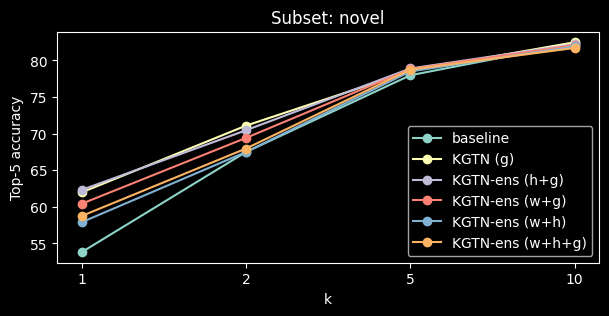

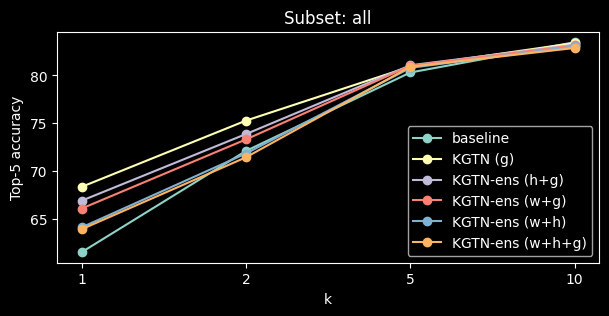

In [64]:
# df_diff
# df_std_mean
plot_comparisons(df, figsize=(7, 3))

### Max (our best)

In [69]:
aggregation_function = "max"
similarity_function = "InnerProduct"
experiment_name = "KGTNens-ResNet50_sgm"
feature_extractor = 'ResNet50_sgm'
kgtn_ens_kgs = [f'hierarchy,glove', f'wiki,glove', f'wiki,hierarchy', f'wiki,hierarchy,glove']

baseline_paths = [f"{BASE_DIR}/KGTN2/results/{feature_extractor}/{s1}" for s1 in 
                    ["baseline", f'KGTN/{similarity_function}', *[f"KGTNens/{s2}-{aggregation_function}-{similarity_function}" for s2 in kgtn_ens_kgs]]]

df = get_experiment_df(baseline_paths, feature_extractor, aggregation_function, similarity_function)
df_diff = get_diff_between_baseline_and_experiments(df, 'KGTN (baseline)', 'KGTN-ens')

df_std_mean = get_experiment_df(baseline_paths, feature_extractor, aggregation_function, similarity_function, results_aggreagation='std')
df_max = get_experiment_df(baseline_paths, feature_extractor, aggregation_function, similarity_function, results_aggreagation='max')

# print(df.filter(['type', 'label', 1, 2, 5, 10]).sort_values(['type', 'label']).to_latex(
#     index=False, 
#     float_format="%.2f",
#     caption='Knowledge graph ensembling (sum), top-5 accuracy',
#     label='tab:ens-sum',
#     ))

In [70]:
get_pivot_df(df)

type                                                                         novel  \
                                                                                 1   
feature_extractor similarity_function aggregation_function label                     
ResNet50_sgm      InnerProduct        max                  KGTN (g)          61.96   
                                                           KGTN-ens (h+g)    62.73   
                                                           KGTN-ens (w+g)    61.21   
                                                           KGTN-ens (w+h)    58.77   
                                                           KGTN-ens (w+h+g)  61.32   
                                                           baseline          53.79   

type                                                                                \
                                                                                 2   
feature_extractor similarity_function aggregation_function label                     
ResNet50_sgm      InnerProduct        max                  KGTN (g)          71.08   
                                                           KGTN-ens (h+g)    71.48   
                                                           KGTN-ens (w+g)    70.66   
                                                           KGTN-ens (w+h)    69.17   
                                                           KGTN-ens (w+h+g)  70.77   
                                                           baseline          67.48   

type                                                                                \
                                                                                 5   
feature_extractor similarity_function aggregation_function label                     
ResNet50_sgm      InnerProduct        max                  KGTN (g)          78.53   
                                                           KGTN-ens (h+g)    78.83   
                                                           KGTN-ens (w+g)    78.60   
                                                           KGTN-ens (w+h)    78.44   
                                                           KGTN-ens (w+h+g)  78.70   
                                                           baseline          77.97   

type                                                                                \
                                                                                10   
feature_extractor similarity_function aggregation_function label                     
ResNet50_sgm      InnerProduct        max                  KGTN (g)          82.48   
                                                           KGTN-ens (h+g)    82.56   
                                                           KGTN-ens (w+g)    82.34   
                                                           KGTN-ens (w+h)    82.25   
                                                           KGTN-ens (w+h+g)  82.38   
                                                           baseline          82.32   

type                                                                           all  \
                                                                                 1   
feature_extractor similarity_function aggregation_function label                     
ResNet50_sgm      InnerProduct        max                  KGTN (g)          68.34   
                                                           KGTN-ens (h+g)    68.58   
                                                           KGTN-ens (w+g)    67.69   
                                                           KGTN-ens (w+h)    66.17   
                                                           KGTN-ens (w+h+g)  67.85   
                                                           baseline          61.50   

type                                                                                \
                                       

In [71]:
get_best_models(df, feature_extractor)

label aggregation_function  \
feature_extractor k  type                                         
ResNet50_sgm      1  all    KGTN-ens (h+g)                  max   
                     novel  KGTN-ens (h+g)                  max   
                  2  all    KGTN-ens (h+g)                  max   
                     novel  KGTN-ens (h+g)                  max   
                  5  all    KGTN-ens (h+g)                  max   
                     novel  KGTN-ens (h+g)                  max   
                  10 all          baseline                  max   
                     novel  KGTN-ens (h+g)                  max   

                           similarity_function  top-5 acc  rank  
feature_extractor k  type                                        
ResNet50_sgm      1  all          InnerProduct      68.58   1.0  
                     novel        InnerProduct      62.73   1.0  
                  2  all          InnerProduct      75.45   1.0  
                     novel        InnerProduct      71.48   1.0  
                  5  all          InnerProduct      81.12   1.0  
                     novel        InnerProduct      78.83   1.0  
                  10 all          InnerProduct      83.48   1.0  
                     novel        InnerProduct      82.56   1.0

In [76]:
get_pivot_df(df_max)

type                                                                         novel  \
                                                                                 1   
feature_extractor similarity_function aggregation_function label                     
ResNet50_sgm      InnerProduct        max                  KGTN (g)          62.42   
                                                           KGTN-ens (h+g)    63.50   
                                                           KGTN-ens (w+g)    61.95   
                                                           KGTN-ens (w+h)    59.73   
                                                           KGTN-ens (w+h+g)  61.90   
                                                           baseline          54.56   

type                                                                                \
                                                                                 2   
feature_extractor similarity_function aggregation_function label                     
ResNet50_sgm      InnerProduct        max                  KGTN (g)          71.60   
                                                           KGTN-ens (h+g)    72.09   
                                                           KGTN-ens (w+g)    70.87   
                                                           KGTN-ens (w+h)    69.42   
                                                           KGTN-ens (w+h+g)  71.23   
                                                           baseline          67.80   

type                                                                                \
                                                                                 5   
feature_extractor similarity_function aggregation_function label                     
ResNet50_sgm      InnerProduct        max                  KGTN (g)          78.87   
                                                           KGTN-ens (h+g)    79.21   
                                                           KGTN-ens (w+g)    78.92   
                                                           KGTN-ens (w+h)    78.75   
                                                           KGTN-ens (w+h+g)  79.16   
                                                           baseline          78.31   

type                                                                                \
                                                                                10   
feature_extractor similarity_function aggregation_function label                     
ResNet50_sgm      InnerProduct        max                  KGTN (g)          83.24   
                                                           KGTN-ens (h+g)    83.13   
                                                           KGTN-ens (w+g)    82.99   
                                                           KGTN-ens (w+h)    82.75   
                                                           KGTN-ens (w+h+g)  82.95   
                                                           baseline          82.85   

type                                                                           all  \
                                                                                 1   
feature_extractor similarity_function aggregation_function label                     
ResNet50_sgm      InnerProduct        max                  KGTN (g)          68.52   
                                                           KGTN-ens (h+g)    68.92   
                                                           KGTN-ens (w+g)    67.87   
                                                           KGTN-ens (w+h)    66.81   
                                                           KGTN-ens (w+h+g)  68.02   
                                                           baseline          62.11   

type                                                                                \
                                       

In [75]:
get_best_models(df_max, feature_extractor="ResNet50_sgm")

label aggregation_function  \
feature_extractor k  type                                         
ResNet50_sgm      1  all    KGTN-ens (h+g)                  max   
                     novel  KGTN-ens (h+g)                  max   
                  2  all    KGTN-ens (h+g)                  max   
                     novel  KGTN-ens (h+g)                  max   
                  5  all    KGTN-ens (h+g)                  max   
                     novel  KGTN-ens (h+g)                  max   
                  10 all    KGTN-ens (h+g)                  max   
                     novel        KGTN (g)                  max   

                           similarity_function  top-5 acc  rank  
feature_extractor k  type                                        
ResNet50_sgm      1  all          InnerProduct      68.92   1.0  
                     novel        InnerProduct      63.50   1.0  
                  2  all          InnerProduct      75.73   1.0  
                     novel        InnerProduct      72.09   1.0  
                  5  all          InnerProduct      81.35   1.0  
                     novel        InnerProduct      79.21   1.0  
                  10 all          InnerProduct      83.86   1.0  
                     novel        InnerProduct      83.24   1.0

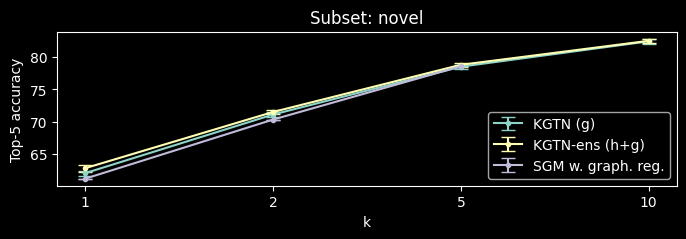

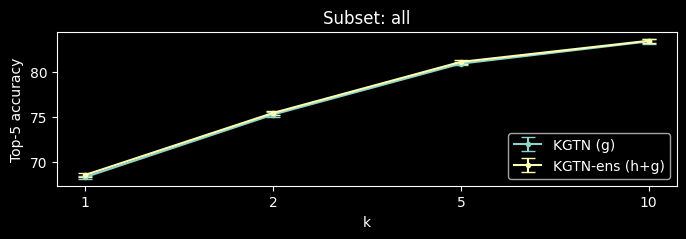

In [68]:
df_shen2021 = pd.DataFrame.from_dict([{1: 61.1, 2: 70.3, 5: 78.6, 10: None, "type": "novel", "label": "SGM w. graph. reg."}])
df_shen2021_std = pd.DataFrame.from_dict([{1: 0, 2: 0, 5: 0, 10: None, "type": "novel", "label": "SGM w. graph. reg."}])

plot_comparisons_with_errorbards(
    pd.concat([df, df_shen2021], ignore_index=True), 
    pd.concat([df_std_mean, df_shen2021_std], ignore_index=True), 
    ['KGTN (g)', 'KGTN-ens (h+g)', "SGM w. graph. reg."],
    # fig_name_prefix="max",
    fix_matplotlib=True,
    figsize=(8, 2)
    # exp_scale_functions=(partial(np.power, 10.0), np.log10),
    )
# df


# ResNet10/18-sgm

In [161]:
aggregation_functions = ["max", "mean"]
similarity_functions = ["InnerProduct", "CosSim", "PearCorr"]
feature_extractors = ['ResNet10_sgm', 'ResNet18_sgm']
kgtn_ens_kgs = [f'hierarchy,glove', f'wiki,glove', f'wiki,hierarchy', f'wiki,hierarchy,glove']

dfs, dfs_std, dfs_max = [], [], []
for fe in feature_extractors:
    baseline_path = f"{BASE_DIR}/KGTN2/results/{fe}/baseline"
    dfs.append(get_experiment_df([baseline_path], fe, "-", "-"))
    dfs_std.append(get_experiment_df([baseline_path], fe, "-", "-", results_aggreagation='std'))
    dfs_max.append(get_experiment_df([baseline_path], fe, "-", "-", results_aggreagation='max'))
    for sf in similarity_functions:
        kgtn_paths = [f"{BASE_DIR}/KGTN2/results/{fe}/KGTN/{sf}"]
        dfs.append(get_experiment_df(kgtn_paths, fe, "-", sf, store_additional_description=True))
        dfs_std.append(get_experiment_df(kgtn_paths, fe, "-", sf, results_aggreagation='std'))
        dfs_max.append(get_experiment_df(kgtn_paths, fe, "-", sf, results_aggreagation='max'))
        for af in aggregation_functions:
            paths = [f"{BASE_DIR}/KGTN2/results/{fe}/KGTNens/{kg}-{af}-{sf}" for kg in kgtn_ens_kgs]
            dfs.append(get_experiment_df(paths, fe, af, sf, store_additional_description=True))
            dfs_std.append(get_experiment_df(paths, fe, af, sf, results_aggreagation='std'))
            dfs_max.append(get_experiment_df(paths, fe, af, sf, results_aggreagation='max'))
            
df = pd.concat(dfs, ignore_index=True)
df_std = pd.concat(dfs_std, ignore_index=True)
df_max = pd.concat(dfs_max, ignore_index=True)
# df

In [162]:
get_pivot_df(df)

type                                                                         novel  \
                                                                                 1   
feature_extractor similarity_function aggregation_function label                     
ResNet10_sgm      -                   -                    baseline          43.92   
                  CosSim              -                    KGTN (g)          47.43   
                                      max                  KGTN-ens (h+g)    46.75   
                                                           KGTN-ens (w+g)    46.31   
                                                           KGTN-ens (w+h)    46.14   
                                                           KGTN-ens (w+h+g)  46.00   
                                      mean                 KGTN-ens (h+g)    47.27   
                                                           KGTN-ens (w+g)    46.73   
                                                           KGTN-ens (w+h)    46.52   
                                                           KGTN-ens (w+h+g)  46.98   
                  InnerProduct        -                    KGTN (g)          44.48   
                                      max                  KGTN-ens (h+g)    43.88   
                                                           KGTN-ens (w+g)    41.89   
                                                           KGTN-ens (w+h)    40.14   
                                                           KGTN-ens (w+h+g)  41.62   
                                      mean                 KGTN-ens (h+g)    38.21   
                                                           KGTN-ens (w+g)    39.54   
                                                           KGTN-ens (w+h)    35.34   
                                                           KGTN-ens (w+h+g)  36.92   
                  PearCorr            -                    KGTN (g)          46.97   
                                      max                  KGTN-ens (h+g)    46.01   
                                                           KGTN-ens (w+g)    45.64   
                                                           KGTN-ens (w+h)    45.40   
                                                           KGTN-ens (w+h+g)  45.50   
                                      mean                 KGTN-ens (h+g)    46.90   
                                                           KGTN-ens (w+g)    46.40   
                                                           KGTN-ens (w+h)    45.90   
                                                           KGTN-ens (w+h+g)  46.59   
ResNet18_sgm      -                   -                    baseline          47.75   
                  CosSim              -                    KGTN (g)          51.60   
                                      max                  KGTN-ens (h+g)    50.79   
                                                           KGTN-ens (w+g)    50.39   
                                                           KGTN-ens (w+h)    50.23   
                                                           KGTN-ens (w+h+g)  49.93   
                                      mean                 KGTN-ens (h+g)    51.54   
                                                           KGTN-ens (w+g)    51.00   
                                                           KGTN-ens (w+h)    50.50   
                                                           KGTN-ens (w+h+g)  50.97   
                  InnerProduct        -                    KGTN (g)          55.40   
                                      max                  KGTN-ens (h+g)    53.93   
                                                           KGTN-ens (w+g)    53.21   
                                                           KGTN-ens (w+h)    49.74   
                                                           KGTN-ens (w+h+g)  52.89   
                                      mean  

In [178]:
get_best_models(df, 'ResNet10_sgm').sort_index().drop("rank", axis=1)

label aggregation_function  \
feature_extractor type  k                                         
ResNet10_sgm      all   1   KGTN-ens (h+g)                 mean   
                        2   KGTN-ens (h+g)                 mean   
                        5   KGTN-ens (h+g)                  max   
                        10  KGTN-ens (w+h)                  max   
                  novel 1         KGTN (g)                    -   
                        2         KGTN (g)                    -   
                        5         baseline                    -   
                        10        KGTN (g)                    -   

                           similarity_function  top-5 acc  
feature_extractor type  k                                  
ResNet10_sgm      all   1             PearCorr      51.97  
                        2               CosSim      61.41  
                        5         InnerProduct      70.41  
                        10              CosSim      75.78  
                  novel 1               CosSim      47.43  
                        2               CosSim      58.63  
                        5                    -      69.46  
                        10              CosSim      74.61

In [179]:
get_best_models(df_max, 'ResNet10_sgm').sort_index().drop("rank", axis=1)

label aggregation_function  \
feature_extractor type  k                                         
ResNet10_sgm      all   1   KGTN-ens (h+g)                 mean   
                        2   KGTN-ens (h+g)                 mean   
                        5   KGTN-ens (h+g)                  max   
                        10  KGTN-ens (w+h)                  max   
                  novel 1         KGTN (g)                    -   
                        2   KGTN-ens (h+g)                 mean   
                        5         baseline                    -   
                        10  KGTN-ens (h+g)                 mean   

                           similarity_function  top-5 acc  
feature_extractor type  k                                  
ResNet10_sgm      all   1             PearCorr      52.26  
                        2               CosSim      61.72  
                        5         InnerProduct      70.95  
                        10              CosSim      76.24  
                  novel 1               CosSim      48.13  
                        2               CosSim      59.22  
                        5                    -      69.96  
                        10              CosSim      75.45

In [180]:
get_best_models(df, 'ResNet18_sgm').sort_index().drop("rank", axis=1)

label aggregation_function  \
feature_extractor type  k                                         
ResNet18_sgm      all   1         KGTN (g)                    -   
                        2   KGTN-ens (h+g)                  max   
                        5         KGTN (g)                    -   
                        10  KGTN-ens (w+g)                  max   
                  novel 1         KGTN (g)                    -   
                        2         KGTN (g)                    -   
                        5         KGTN (g)                    -   
                        10        baseline                    -   

                           similarity_function  top-5 acc  
feature_extractor type  k                                  
ResNet18_sgm      all   1         InnerProduct      60.64  
                        2         InnerProduct      68.33  
                        5         InnerProduct      76.82  
                        10        InnerProduct      79.94  
                  novel 1         InnerProduct      55.40  
                        2         InnerProduct      64.44  
                        5         InnerProduct      74.46  
                        10                   -      79.04

In [181]:
get_best_models(df_max, 'ResNet18_sgm').sort_index().drop("rank", axis=1)

label aggregation_function  \
feature_extractor type  k                                           
ResNet18_sgm      all   1           KGTN (g)                    -   
                        2     KGTN-ens (h+g)                  max   
                        5           KGTN (g)                    -   
                        10  KGTN-ens (w+h+g)                  max   
                  novel 1           KGTN (g)                    -   
                        2           KGTN (g)                    -   
                        5           KGTN (g)                    -   
                        10          baseline                    -   

                           similarity_function  top-5 acc  
feature_extractor type  k                                  
ResNet18_sgm      all   1         InnerProduct      61.09  
                        2         InnerProduct      68.62  
                        5         InnerProduct      77.23  
                        10        InnerProduct      80.38  
                  novel 1         InnerProduct      56.12  
                        2         InnerProduct      64.73  
                        5         InnerProduct      75.04  
                        10                   -      79.54

### LATEX

In [208]:
cols_to_remove = ['feature_extractor', 'similarity_function', 'aggregation_function']
header_row_1 = "& \multicolumn{4}{c}{novel} & \multicolumn{4}{c}{all} \\\\ \cmidrule(lr){2-5} \cmidrule(lr){6-9}"
header_row_2 = "& \multicolumn{1}{c}{1} & \multicolumn{1}{c}{2} & \multicolumn{1}{c}{5} & \multicolumn{1}{c}{10} & \multicolumn{1}{c}{1} & \multicolumn{1}{c}{2} & \multicolumn{1}{c}{5} & \multicolumn{1}{c}{10} \\\\"
escape_char = "\\"

for feature_extractor in [f'ResNet{r}_sgm' for r in [10, 18]]:

    df_replaced = (df
                   .replace({'InnerProduct': 'IP', 'CosSim': 'CS', 'PearCorr': 'PC'})
                   .replace({'KGTN-ens': 'ours', r'\,\ \-': ''}, regex=True))
    df_replaced.label = df_replaced.label + ", " + df_replaced.similarity_function + ", " + df_replaced.aggregation_function
    df_replaced

    pivot_df = get_pivot_df(df_replaced[df_replaced.feature_extractor == feature_extractor])

    
    latex_code = (pivot_df
    .reset_index()
    .set_index('label')
    .drop(labels=[(c, '') for c in cols_to_remove], axis=1)
    .to_latex(
        caption=f"Mean top-5 accuracies averaged over 5 experiments for {feature_extractor.replace('_', escape_char +'_')}.",
        label=f"tab:results-{feature_extractor}",
        position="h",
        )
    )
    latex_code_as_list = latex_code.split('\n')
    latex_code_as_list[6] = header_row_1
    latex_code_as_list[7] = header_row_2
    latex_code_as_list[8] = ""
    for idx, l in enumerate(latex_code_as_list):
        if l.startswith("KGTN ("):
            latex_code_as_list[idx] = "\cmidrule(lr){2-9} " + latex_code_as_list[idx] + "\cmidrule(lr){2-9} \n"
    latex_code_fixed = "\n".join(latex_code_as_list)
    # print(latex_code_fixed)
    with open(f"../../tables/results-{feature_extractor}.tex", "w") as text_file:
        text_file.write(latex_code_fixed)

/var/folders/16/b95ft7d93ws0vls5v2fjj1j40000gn/T/ipykernel_5503/839293179.py:17: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = (pivot_df
/var/folders/16/b95ft7d93ws0vls5v2fjj1j40000gn/T/ipykernel_5503/839293179.py:17: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = (pivot_df


In [218]:

for d, filename, caption in [(df, "average", "Results averaged on 5 different runs"), (df_max, "best", "Best single results")]:
    (pd
    .concat([
        get_best_models(d, 'ResNet10_sgm').sort_index().drop("rank", axis=1), 
        get_best_models(d, 'ResNet18_sgm').sort_index().drop("rank", axis=1)])
    .replace({"feature_extractor": "FE"})
    .replace({'InnerProduct': 'IP', 'CosSim': 'CS', 'PearCorr': 'PC'})
    .reset_index()
    .rename(columns={"feature_extractor": "FE", "aggregation_function": "AF", "similarity_function": "SF", "label": "model", "k": "k"})
    .set_index(["FE", "type", "k"])
    ).to_latex(
        buf=f"../../tables/results-{filename}.tex",
        caption=f"{caption} for each FE, type and $k$.",
        label=f"tab:results-best",
        position="h",
    )

/var/folders/16/b95ft7d93ws0vls5v2fjj1j40000gn/T/ipykernel_5503/3200584832.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  (pd
/var/folders/16/b95ft7d93ws0vls5v2fjj1j40000gn/T/ipykernel_5503/3200584832.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  (pd


### STD anylysis

In [49]:
get_pivot_df(df_std)

type                                                                      novel  \
                                                                              1   
feature_extractor similarity_function aggregation_function label                  
ResNet10_sgm      -                   -                    baseline        0.30   
                  CosSim              -                    KGTN (g)        0.46   
                                      max                  KGTN-ens (h+g)  0.55   
                                                           KGTN-ens (w+g)  0.51   
                                      mean                 KGTN-ens (h+g)  0.55   
                                                           KGTN-ens (w+g)  0.47   
                  InnerProduct        -                    KGTN (g)        0.52   
                                      max                  KGTN-ens (h+g)  0.59   
                                                           KGTN-ens (w+g)  0.63   
                                      mean                 KGTN-ens (h+g)  0.32   
                                                           KGTN-ens (w+g)  0.56   
                  PearCorr            -                    KGTN (g)        0.36   
                                      max                  KGTN-ens (h+g)  0.45   
                                                           KGTN-ens (w+g)  0.67   
                                      mean                 KGTN-ens (h+g)  0.53   
                                                           KGTN-ens (w+g)  0.48   
ResNet18_sgm      -                   -                    baseline        0.67   
                  CosSim              -                    KGTN (g)        0.38   
                                      max                  KGTN-ens (h+g)  0.48   
                                                           KGTN-ens (w+g)  0.50   
                                      mean                 KGTN-ens (h+g)  0.52   
                                                           KGTN-ens (w+g)  0.57   
                  InnerProduct        -                    KGTN (g)        0.44   
                                      max                  KGTN-ens (h+g)  0.51   
                                                           KGTN-ens (w+g)  0.78   
                                      mean                 KGTN-ens (h+g)  0.67   
                                                           KGTN-ens (w+g)  0.61   
                  PearCorr            -                    KGTN (g)        0.33   
                                      max                  KGTN-ens (h+g)  0.40   
                                                           KGTN-ens (w+g)  0.50   
                                      mean                 KGTN-ens (h+g)  0.51   
                                                           KGTN-ens (w+g)  0.58   

type                                                                             \
                                                                              2   
feature_extractor similarity_function aggregation_function label                  
ResNet10_sgm      -                   -                    baseline        0.50   
                  CosSim              -                    KGTN (g)        0.32   
                                      max                  KGTN-ens (h+g)  0.42   
                                                           KGTN-ens (w+g)  0.41   
                                      mean                 KGTN-ens (h+g)  0.41   
                                                           KGTN-ens (w+g)  0.52   
                  InnerProduct        -                    KGTN (g)        0.62   
                                      max                  KGTN-ens (h+g)  0.67   
                                                           KGTN-ens (w+g)  0.54   
                                      mean                 KGTN-ens (h+g)  0.24   
               

# ResNet50-sgm CosSim-Max experiment (old code)

In [21]:
results = []
for suffix in ['hierarchy,glove-max-CosSim', 'wiki,glove-max-CosSim', 'wiki,hierarchy-max-CosSim', 'wiki,hierarchy,glove-max-CosSim']:
    r1, r2 = parse_results(f'{PROJECT_DIR}/results/KGTNens-181121/{suffix}', 'ResNet50_sgm', 0.01, 0.0001)
    results.append(r1)
    results.append(r2)


for suffix in [
    # 'KGTN/CosSim', 
    'KGTN_InnerProduct', 
    # 'KGTN_PearCorr', 
    # 'KGTN_hierarchy'
    ]:
    r1, r2 = parse_results(f'{PROJECT_DIR}/results/{suffix}', 'ResNet50_sgm', 0.01, 0.0001)
    results.append(r1)
    results.append(r2)

# r1, r2 = parse_results(f'/tf/KGTN2/results/baseline', 'ResNet50_sgm', 0.1, 0.0001)
# results.append(r1), results.append(r2)

df = pd.DataFrame(results)
df['label'] = df['label'].apply(lambda x: x.split('/')[-1])
df['label'] = df['label'].replace(['KGTN_InnerProduct'], 'SOTA (KGTN)')

print(df.filter(['type', 'label', 1, 2, 5, 10]).sort_values(['type', 'label']).to_latex(
    index=False, 
    float_format="%.2f",
    caption='Knowledge graph ensembling (with cosine similarity), top-5 accuracy',
    label='tab:results_cosine',
    ))

\begin{table}
\centering
\caption{Knowledge graph ensembling (with cosine similarity), top-5 accuracy}
\label{tab:results_cosine}
\begin{tabular}{llrrrr}
\toprule
 type &                           label &     1 &     2 &     5 &    10 \\
\midrule
  all &                     SOTA (KGTN) & 68.34 & 75.27 & 80.92 & 83.40 \\
  all &      hierarchy,glove-max-CosSim & 64.86 & 73.72 & 80.05 & 83.46 \\
  all &           wiki,glove-max-CosSim & 64.43 & 73.44 & 80.01 & 83.38 \\
  all & wiki,hierarchy,glove-max-CosSim & 63.81 & 73.12 & 79.99 & 83.44 \\
  all &       wiki,hierarchy-max-CosSim & 63.87 & 73.23 & 80.00 & 83.43 \\
novel &                     SOTA (KGTN) & 61.96 & 71.08 & 78.53 & 82.48 \\
novel &      hierarchy,glove-max-CosSim & 59.57 & 69.40 & 77.29 & 81.89 \\
novel &           wiki,glove-max-CosSim & 58.34 & 68.75 & 77.24 & 81.84 \\
novel & wiki,hierarchy,glove-max-CosSim & 57.75 & 68.44 & 77.20 & 81.90 \\
novel &       wiki,hierarchy-max-CosSim & 57.35 & 68.50 & 77.27 & 81.90 \\
\bo

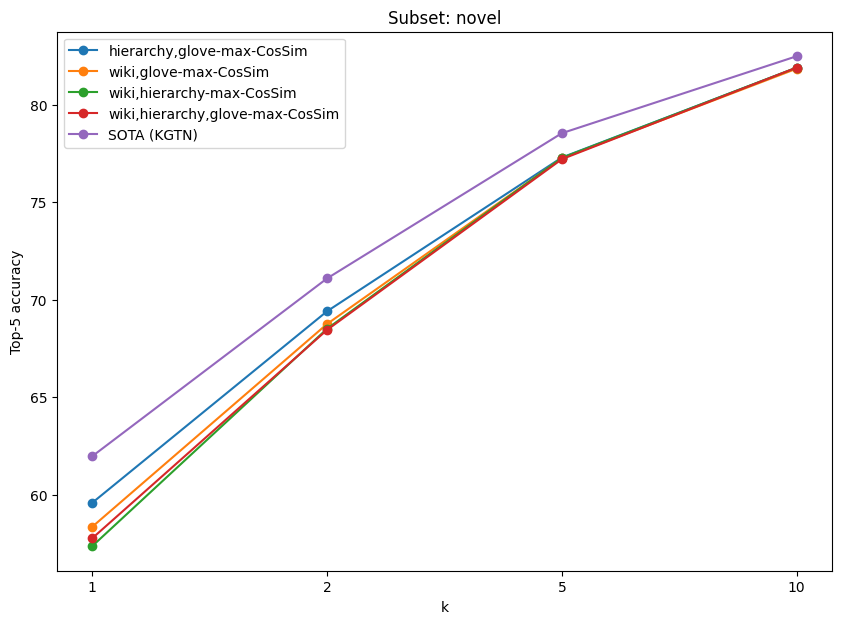

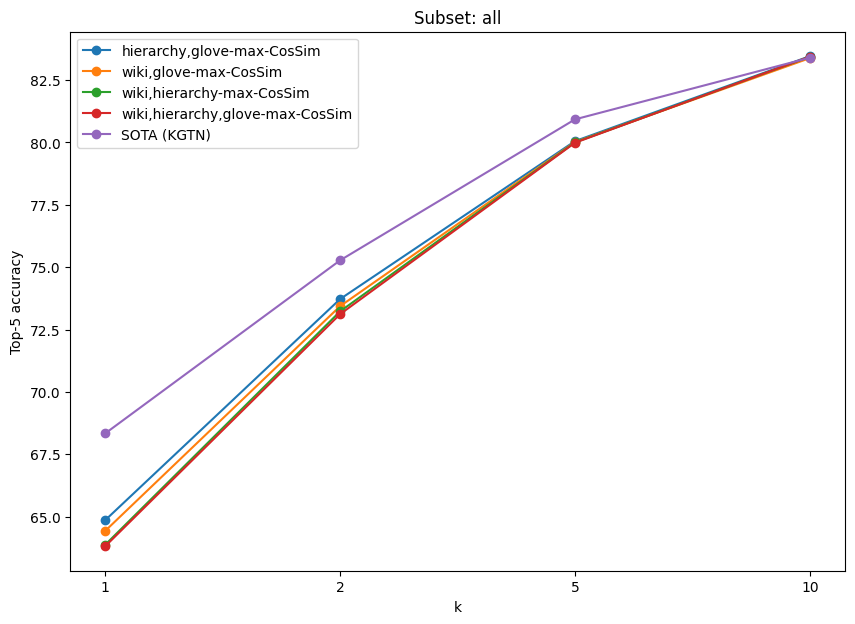

In [22]:

labels = ["1", "2", "5", "10"]

for current_type in ['novel', 'all']:
    plt.figure(figsize=(10,7))
    for x in df[df.type == current_type].iterrows():
        # print(x[1][:4].tolist())
        plt.plot(labels, x[1][:4].tolist(), marker='o', label=x[1]['label'])
        # plt.yscale('log')
        plt.legend()
        plt.title(f'Subset: {current_type}')
        plt.ylabel('Top-5 accuracy')
        plt.xlabel('k')

    # plt.show()
    tikzplotlib.save(f"{FIGURES_DIR}/max_{current_type}_cossim.tex")


In [23]:
df[df['type']=='all']

,1,2,5,10,type,label
1,64.858383,73.720710,80.051282,83.455621,all,"hierarchy,glove-max-CosSim"
3,64.429191,73.435897,80.014990,83.379093,all,"wiki,glove-max-CosSim"
5,63.872978,73.226824,80.000789,83.433531,all,"wiki,hierarchy-max-CosSim"
7,63.813018,73.115582,79.986588,83.439053,all,"wiki,hierarchy,glove-max-CosSim"
9,68.336095,75.273373,80.923866,83.396450,all,SOTA (KGTN)
